In [ ]:
!git clone https://github.com/JeffSackmann/tennis_wta.git

Cloning into 'tennis_wta'...
remote: Enumerating objects: 3834, done.
remote: Counting objects: 100% (600/600), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 3834 (delta 418), reused 585 (delta 404), pack-reused 3234 (from 1)
Receiving objects: 100% (3834/3834), 216.64 MiB | 14.48 MiB/s, done.
Resolving deltas: 100% (2840/2840), done.
Updating files: 100% (124/124), done.


In [ ]:
import pandas as pd
import logging
import glob


files = glob.glob("tennis_wta/wta_matches_*.csv")
df_list = [pd.read_csv(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

df = df[df['winner_name'].notna() & df['loser_name'].notna()]
df = df[~df['score'].str.contains("W/O", na=False)]

wins = df['winner_name'].value_counts()
losses = df['loser_name'].value_counts()

# Combine into a DataFrame
players = pd.DataFrame({
    'wins': wins,
    'losses': losses
}).fillna(0)

players['matches'] = players['wins'] + players['losses']
players['win_pct'] = players['wins'] / players['matches']
players = players[players['matches'] > 100]


recent_df = df[df['tourney_date'] >= 20230000]
active_players = set(recent_df['winner_name']).union(set(recent_df['loser_name']))

players = players[players.index.isin(active_players)]

top10 = players.sort_values('win_pct', ascending=False).head(10)
print(top10[['wins', 'losses', 'matches', 'win_pct']])



<ipython-input-3-7c75817b4de3>:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in files]
<ipython-input-3-7c75817b4de3>:6: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in files]
<ipython-input-3-7c75817b4de3>:6: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in files]
<ipython-input-3-7c75817b4de3>:6: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in files]


                      wins  losses  matches   win_pct
Iga Swiatek          336.0    76.0    412.0  0.815534
Brenda Fruhvirtova   114.0    30.0    144.0  0.791667
Mirra Andreeva       109.0    34.0    143.0  0.762238
Sonay Kartal         141.0    44.0    185.0  0.762162
Alexandra Shubladze   93.0    31.0    124.0  0.750000
Venus Williams       819.0   279.0   1098.0  0.745902
Elena Pridankina     130.0    51.0    181.0  0.718232
Natalija Senic       141.0    56.0    197.0  0.715736
Fangran Tian          72.0    29.0    101.0  0.712871
Kaitlin Quevedo       78.0    32.0    110.0  0.709091


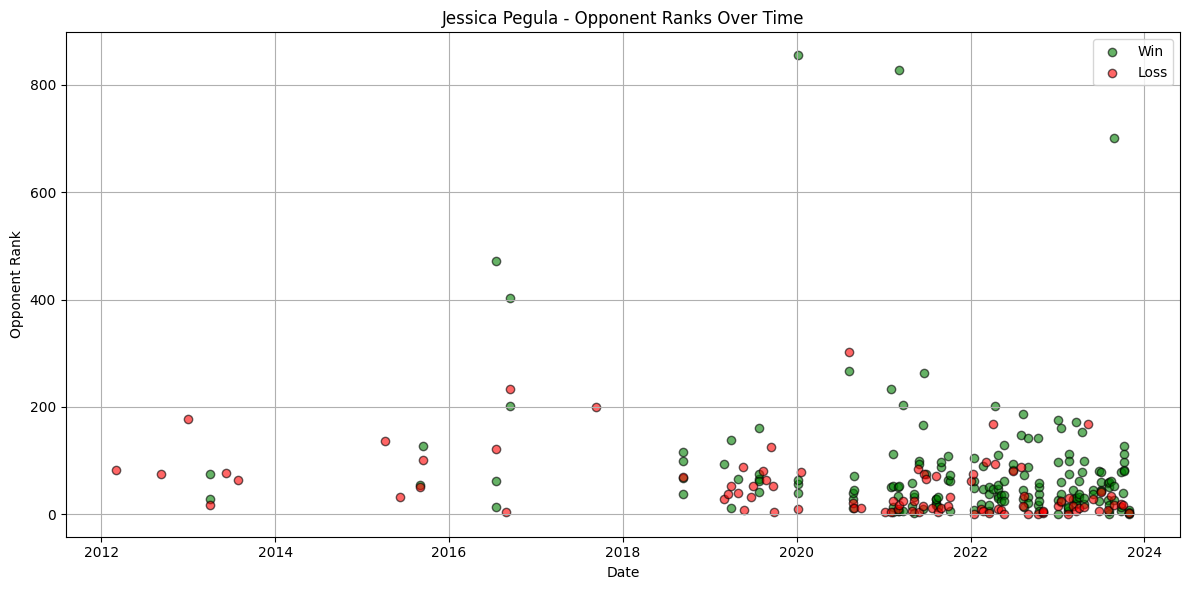

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
import glob


def plot_opponent_ranks_over_time(player_name, df):

    df_player = df[(df['winner_name'] == player_name) | (df['loser_name'] == player_name)].copy()


    df_player['match_date'] = pd.to_datetime(df_player['tourney_date'], format='%Y%m%d')
    df_player['result'] = df_player['winner_name'].apply(lambda x: 'Win' if x == player_name else 'Loss')
    df_player['opponent_rank'] = df_player.apply(
        lambda row: row['loser_rank'] if row['winner_name'] == player_name else row['winner_rank'], axis=1
    )


    df_player = df_player[df_player['opponent_rank'].notna()]

    # Plot
    colors = {'Win': 'green', 'Loss': 'red'}
    plt.figure(figsize=(12, 6))
    for result in ['Win', 'Loss']:
        subset = df_player[df_player['result'] == result]
        plt.scatter(subset['match_date'], subset['opponent_rank'],
                    c=colors[result], label=result, alpha=0.6, edgecolor='k')

    #plt.gca().invert_yaxis()  # So #1 opponents are at the top
    plt.title(f"{player_name} - Opponent Ranks Over Time")
    plt.xlabel("Date")
    plt.ylabel("Opponent Rank")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


years = range(2010, 2024)

df = pd.concat([pd.read_csv(f"tennis_wta/wta_matches_{y}.csv") for y in years], ignore_index=True)

plot_opponent_ranks_over_time("Jessica Pegula", df)

In [ ]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import layout
import glob

output_notebook()  # for Jupyter notebooks; remove if using `output_file()` instead

def plot_opponent_ranks_over_time(player_name, df):
    df_player = df[(df['winner_name'] == player_name) | (df['loser_name'] == player_name)].copy()

    df_player['match_date'] = pd.to_datetime(df_player['tourney_date'], format='%Y%m%d')
    df_player['result'] = df_player['winner_name'].apply(lambda x: 'Win' if x == player_name else 'Loss')
    df_player['opponent_rank'] = df_player.apply(
        lambda row: row['loser_rank'] if row['winner_name'] == player_name else row['winner_rank'], axis=1
    )

    df_player = df_player[df_player['opponent_rank'].notna()]

    # Split by result
    win_df = df_player[df_player['result'] == 'Win']
    loss_df = df_player[df_player['result'] == 'Loss']

    # Create ColumnDataSource
    win_source = ColumnDataSource(win_df)
    loss_source = ColumnDataSource(loss_df)

    # Create figure
    p = figure(title=f"{player_name} - Opponent Ranks Over Time",
               x_axis_label='Date',
               y_axis_label='Opponent Rank',
               x_axis_type='datetime',
               width=900, height=500)

    # Scatter plots for wins and losses
    p.circle('match_date', 'opponent_rank', source=win_source,
             color='green', size=6, alpha=0.6, legend_label="Win")
    p.circle('match_date', 'opponent_rank', source=loss_source,
             color='red', size=6, alpha=0.6, legend_label="Loss")

    # Add hover tool
    hover = HoverTool(tooltips=[
        ("Date", "@match_date{%F}"),
        ("Opponent Rank", "@opponent_rank"),
        ("Result", "@result")
    ], formatters={"@match_date": "datetime"})
    p.add_tools(hover)

    # Invert y-axis so rank #1 is at the top
    #p.y_range.flipped = True

    p.legend.location = "top_left"
    p.legend.click_policy = "hide"
    show(p)


# Load data
years = range(2010, 2024)
df = pd.concat([pd.read_csv(f"tennis_wta/wta_matches_{y}.csv") for y in years], ignore_index=True)

plot_opponent_ranks_over_time("Jessica Pegula", df)
